# Customer Segmentation using K-Means

In [95]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
data = pd.read_csv("Online+Retail.csv",encoding= 'unicode_escape')
data.head()

In [72]:
data.info()
# total 8 variables, 5 categorical, 3 numerical.
# Description and CustomerID having null value present.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [73]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Clean data (missing values, drop, unnecessary data)

In [74]:
# handle null values
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [75]:
# there is almost 25% of rows missing in CustomerID.
# dropping these column is not feasible because CustomerID gives info of customer and without that segmentation is not possible.
# let's drop all rows which have null values.
data = data.dropna()
data.shape

(406829, 8)

In [76]:
data.info()
# no null values now.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


# Prepare data for modeling
1. --R : Recency -> Number of days since last purchase
2.  --F : Frequency -> Number of transactions
3. --M : Monetary -> Total amount of transactions

 based on these behaviour customer segmentation should be performed

In [77]:
# making new column amount to have info of total amount at a time of amount of quantity purchase
data['amount'] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [78]:
# monetary 
group_data = data.groupby('CustomerID')['amount'].sum()
group_data = group_data.reset_index()
group_data.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [79]:
# Frequency
group_freq = data.groupby('CustomerID')['InvoiceNo'].count()
group_freq = group_freq.reset_index()
group_freq.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [80]:
# merge both data frame to have both frequency and amount.
group_df = pd.merge(group_data,group_freq, on="CustomerID", how = "inner")
group_df.head(2)

,CustomerID,amount,InvoiceNo
0,12346.0,0.0,2
1,12347.0,4310.0,182


In [81]:
# change InvoceNo column to frequency for correct readablity
group_df.columns = ["CustomerID","amount", "frequency"]
group_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [82]:
# recency
# first convert to DateTime format
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],
                                     format='%d-%m-%Y %H:%M')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [83]:
# compute max date to campare min date of indivisual customer to finf recency
max_date = max(data['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [84]:
# now compute the difference for each of Invoice date from max
data['diff_date'] = max_date - data['InvoiceDate']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [85]:
last_purchase = data.groupby('CustomerID')['diff_date'].min()
last_purchase.reset_index()
last_purchase.head()

CustomerID
12346.0   325 days 02:33:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
Name: diff_date, dtype: timedelta64[ns]

In [86]:
group_dataframe = pd.merge(group_df, last_purchase, on = "CustomerID", how = 'inner')
group_dataframe.columns = ['CustomerID','amount','frequency','recency']
group_dataframe.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [87]:
# extract days only
group_dataframe['recency'] = group_dataframe['recency'].dt.days
group_dataframe.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [89]:
#  rescaling
df = group_dataframe[['amount','frequency','recency']]
df.head()

,amount,frequency,recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [91]:
# instantiate 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled.shape

(4372, 3)

In [94]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['amount','frequency','recency']
df_scaled.head()

,amount,frequency,recency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


# Modelling

In [96]:
# K-Means with arbitrary K
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [97]:
kmeans.labels_

array([0, 1, 1, ..., 1, 1, 1])

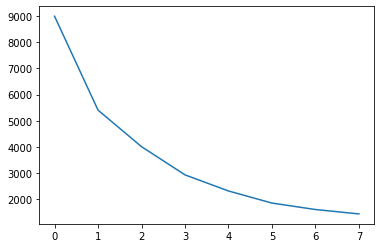

In [100]:
# finding optimal K
# elbow curve/SSD(Sum of Squared disance)
ssd = list()
for K in range(2,10):
    kmeans = KMeans(n_clusters=K, max_iter=50)
    kmeans.fit(df_scaled)
    ssd.append(kmeans.inertia_)
    
# plot ssd
plt.plot(ssd)
plt.show()

In [101]:
# idea is SSD will be 0 if K = data sample, we will stop from the point where it stops to converge
# in above we can stop at 3 

In [102]:
# final model
kmeans = KMeans(n_clusters=3,max_iter=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [103]:
kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [104]:
df_scaled['ClusterID'] = kmeans.labels_
df_scaled.head()

,amount,frequency,recency,ClusterID
0,-0.231001,-0.391720,2.322023,1
1,0.293432,0.382657,-0.893733,0
2,-0.012316,-0.266959,-0.169196,0
3,-0.017146,-0.086271,-0.725005,0
4,-0.190312,-0.327188,2.163220,1


<AxesSubplot:xlabel='ClusterID', ylabel='amount'>

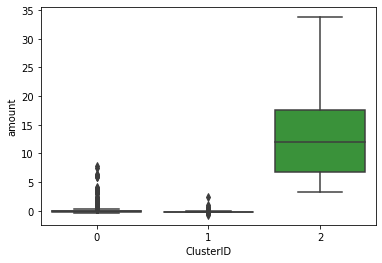

In [105]:
# plot
sns.boxplot(x='ClusterID',y='amount', data=df_scaled)

<AxesSubplot:xlabel='ClusterID', ylabel='recency'>

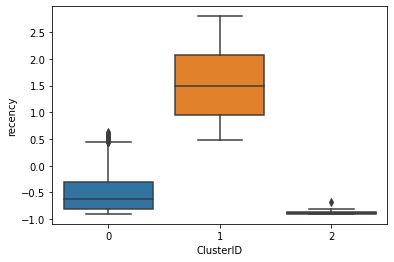

In [106]:
sns.boxplot(x='ClusterID',y='recency', data=df_scaled)

<AxesSubplot:xlabel='ClusterID', ylabel='frequency'>

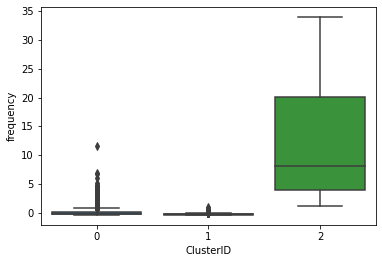

In [107]:
sns.boxplot(x='ClusterID',y='frequency', data=df_scaled)

Git :  Git is a version control software
GitHub : GitHub is Git Repository hosting platform













